<a href="https://colab.research.google.com/github/vedranaa/BugNist/blob/master/neural_fields_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural fields for image fitting based on SIREN and NeRF

Based on [Siren Exploration notebook](https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb) and tiny nerf from [NeRF github page](https://github.com/bmild/nerf).




In [ ]:
import torch
from torch import nn
import skimage
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt

Define models: Siren and Nerflike.

In [ ]:
# ---------- Siren ----------

class SineLayer(nn.Module):

    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega.
    def __init__(self, indim, outdim, bias=True, is_first=False, omega=30):
        super().__init__()
        self.omega = omega
        self.is_first = is_first
        self.indim = indim
        self.linear = nn.Linear(indim, outdim, bias=bias)

        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.indim, 1 / self.indim)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.indim) / self.omega,
                                             np.sqrt(6 / self.indim) / self.omega)

    def forward(self, input):
        return torch.sin(self.omega * self.linear(input))  # Here is sine activation!!!


class Siren(nn.Module):
    def __init__(self, indim=2, outdim=1, nr_hidden=3, hiddendim=256,
                 outermost_linear=True, first_omega=30, hidden_omega=30):
        super().__init__()

        layers = []
        layers.append(SineLayer(indim, hiddendim, is_first=True, omega=first_omega))

        for i in range(nr_hidden):
            layers.append(SineLayer(indim=hiddendim, outdim=hiddendim,
                                      is_first=False, omega=hidden_omega))

        if outermost_linear:
            final_linear = nn.Linear(hiddendim, outdim)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hiddendim) / hidden_omega,
                                              np.sqrt(6 / hiddendim) / hidden_omega)

            layers.append(final_linear)
        else:
            layers.append(SineLayer(indim=hiddendim, outdim=outdim,
                                      is_first=False, omega=hidden_omega))

        self.net = nn.Sequential(*layers)


    def forward(self, coords):
        output = self.net(coords)
        return output


# ---------- Nerflike ----------

class Block(nn.Module):

    def __init__(self, indim, outdim, hiddendim, nr_hidden, last_activated):

        super().__init__()
        layers = []
        layers.append(nn.Linear(indim, hiddendim))
        layers.append(nn.ReLU())
        for i in range(nr_hidden):
            layers.append(nn.Linear(hiddendim, hiddendim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hiddendim, outdim))
        if last_activated:
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

    def forward(self, input):
        return self.net(input)


def encoding(input, len_embed):
      encoded = [input]
      for l in range(len_embed):
          encoded.append(torch.sin(2**l * input))
          encoded.append(torch.cos(2**l * input))
      return torch.cat(encoded, dim=-1)


class Nerflike(nn.Module):
    def __init__(self, indim=2, outdim=1, len_embed=10, hiddendim=256):

        super().__init__()

        self.len_embed = len_embed
        embeddim = indim + indim*2*len_embed

        self.block1 = Block(indim=embeddim,
                            outdim=hiddendim,
                            hiddendim=hiddendim,
                            nr_hidden=3,
                            last_activated=True)

        self.block2 = Block(indim=hiddendim+embeddim,
                            outdim=outdim,
                            hiddendim=hiddendim,
                            nr_hidden=3,
                            last_activated=False)


    def forward(self, input):

        encoded = encoding(input, self.len_embed)
        output = self.block1(encoded)
        output = self.block2(torch.cat([output, encoded], dim=-1))
        return output


Helping functions.

In [ ]:
def get_pixel_coords(imshape):
    H, W = imshape[:2]
    i, j = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij')
    mgrid = torch.stack((i, j), dim=-1)
    coords = mgrid.reshape(-1, 2)
    return(coords)


def show_predictions(ax, predictions, imshape):
    D = 1 if len(imshape)<3 else imshape[2]
    p = predictions.cpu().view(imshape).detach()
    if D==1:
        ax.imshow(p, vmin=-1, vmax=1, cmap=plt.cm.gray)
    elif D==3:
        ax.imshow(torch.clamp(0.5*(p+1), min=0, max=1))


def show_residual(ax, residual, imshape):
    D = 1 if len(imshape)<3 else imshape[2]
    r = residual.cpu().view(imshape).detach()
    if D==1:
        ax.imshow(r, vmin=-1, vmax=1, cmap=plt.cm.seismic)
    elif D==3:
        ax.imshow(torch.clamp(0.5*(r+1), min=0, max=1))


Get input and ground truth in correct format.

In [ ]:
image = skimage.data.cat()
image = skimage.transform.rescale(image, 0.25, anti_aliasing=False, multichannel=image.ndim>2)
image = image.astype(float)
image -= image.min()
image *= (1/image.max())

coords = get_pixel_coords(image.shape)
D = 1 if len(image.shape)<3 else image.shape[2]  # 1 for grayscale, 3 for RGB
values_gt = torch.Tensor(2*image - 1).view(-1, D)
coords, values_gt = coords.cuda(), values_gt.cuda()

<ipython-input-4-0ec8d7a2df96>:2: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  image = skimage.transform.rescale(image, 0.25, anti_aliasing=False, multichannel=image.ndim>2)


Fit the model to the image data.

Step 0, Total loss 0.183802


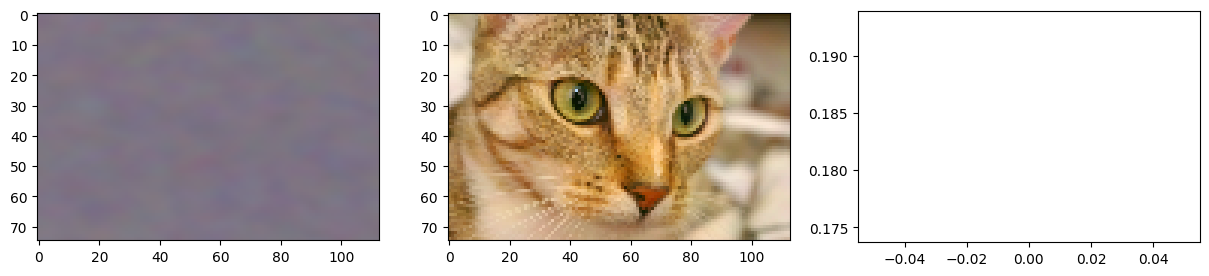

Step 10, Total loss 0.059905


Step 20, Total loss 0.031690


Step 30, Total loss 0.019093


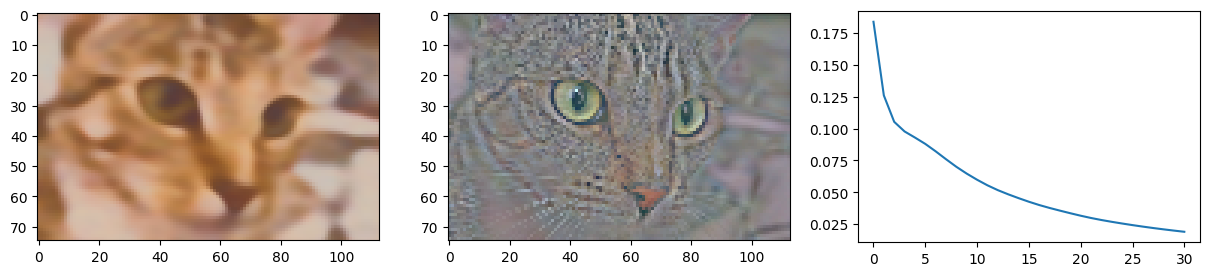

Step 40, Total loss 0.012847


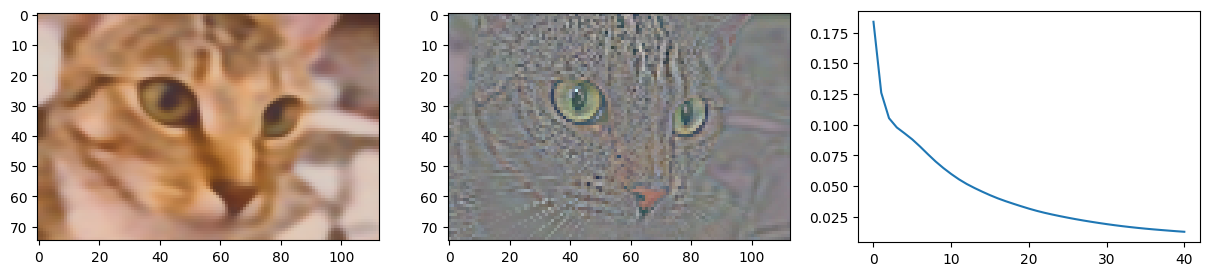

Step 50, Total loss 0.009622


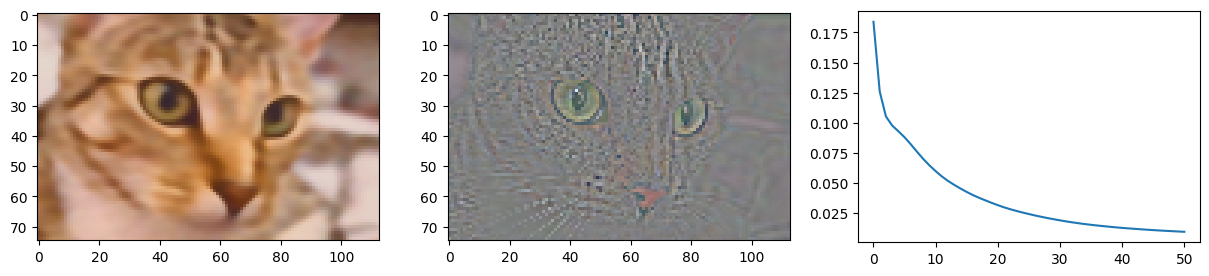

Step 60, Total loss 0.007721


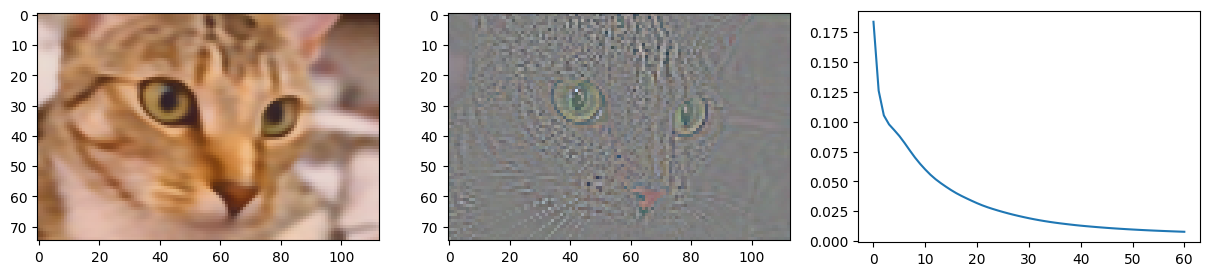

Step 70, Total loss 0.006487


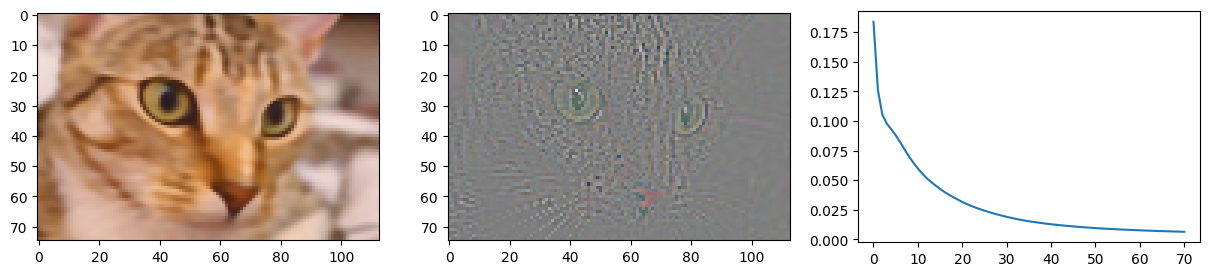

Step 80, Total loss 0.005629


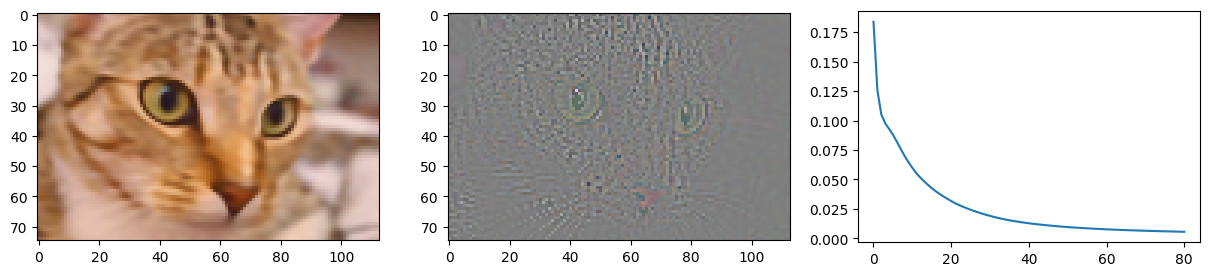

Step 90, Total loss 0.004977


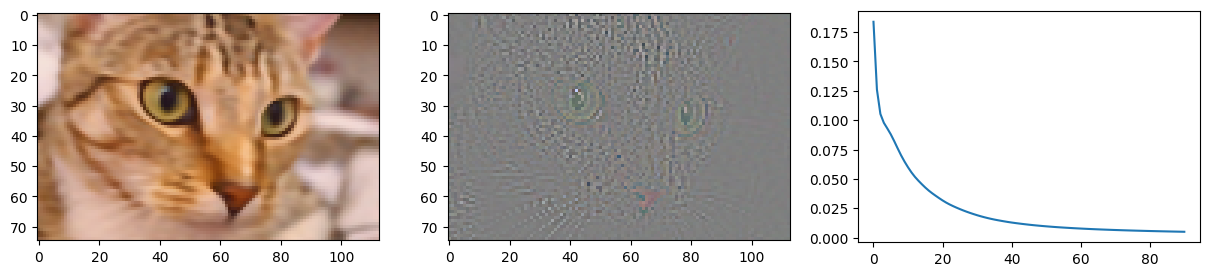

Step 100, Total loss 0.004444


Step 110, Total loss 0.003984


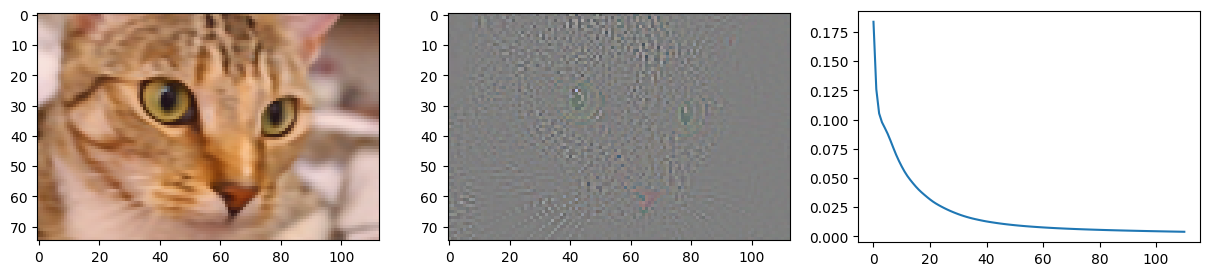

Step 120, Total loss 0.003576


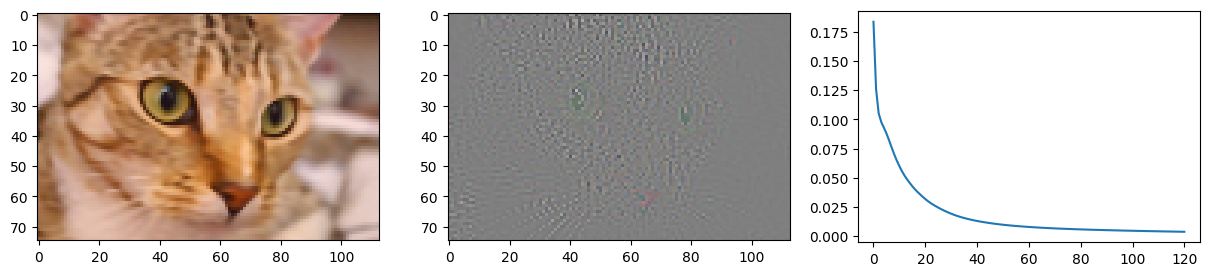

Step 130, Total loss 0.003215


Step 140, Total loss 0.002906


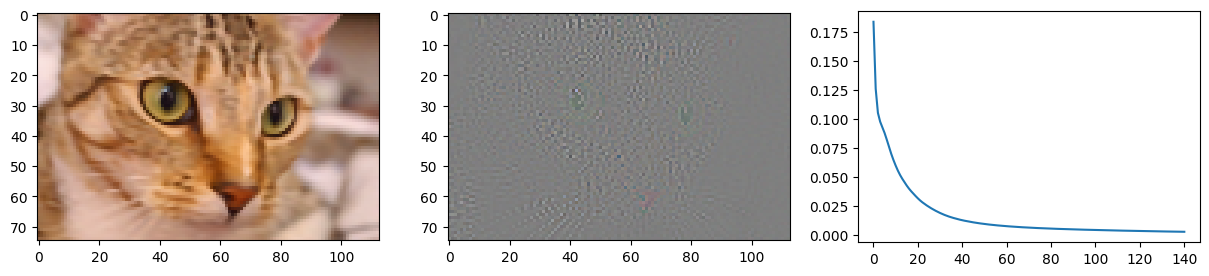

Step 150, Total loss 0.002645


Step 160, Total loss 0.002478


Step 170, Total loss 0.002198


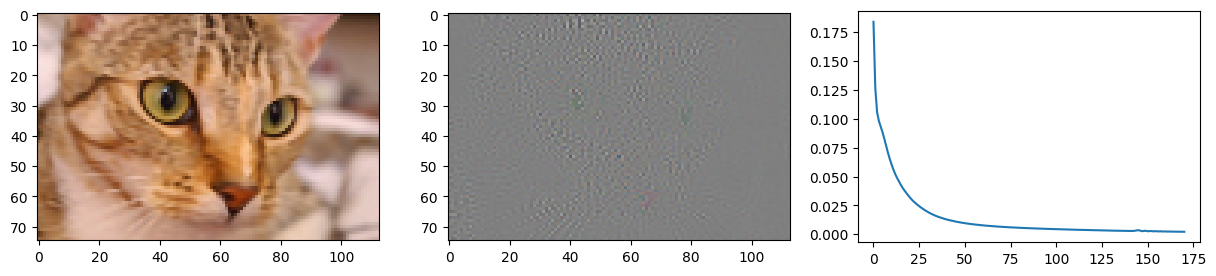

Step 180, Total loss 0.001975


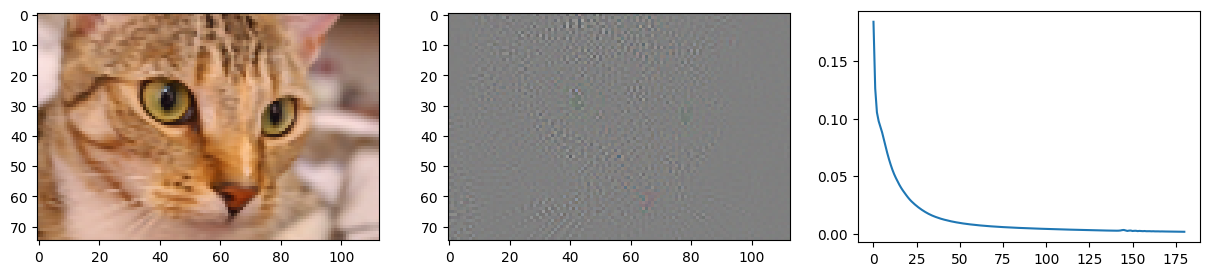

Step 190, Total loss 0.001771


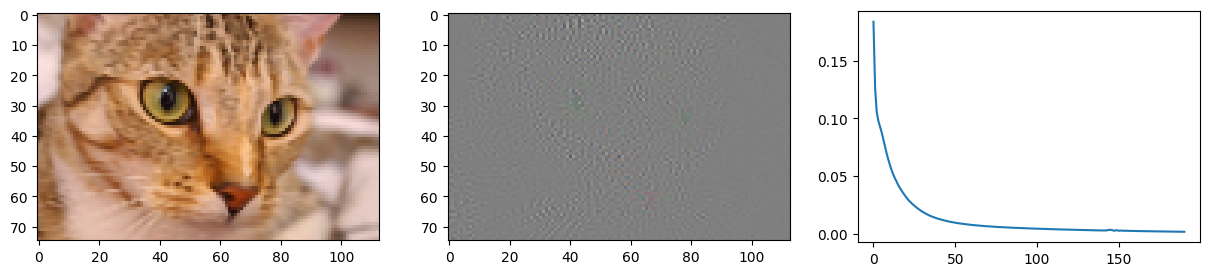

Step 200, Total loss 0.001587


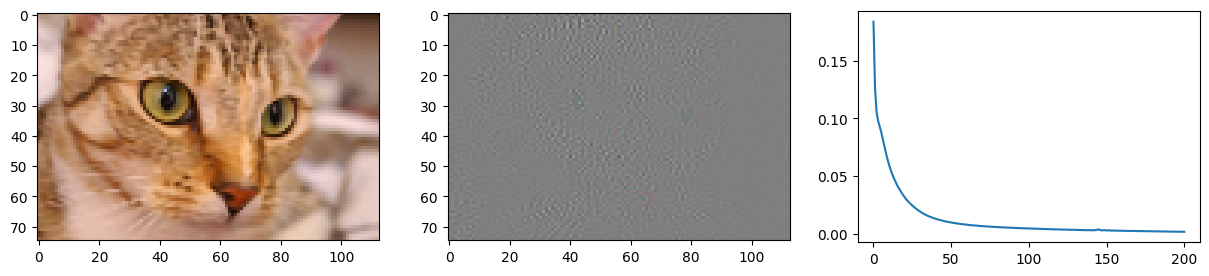

In [ ]:
model = Siren(outdim=D).cuda()

total_steps = 201 # Since the whole image is our dataset, this is number of gradient descent steps.
steps_til_summary = 10
optim = torch.optim.Adam(lr=1e-4, params=model.parameters())
losses = []

for step in range(total_steps):

    predictions = model(coords)
    residual = values_gt - predictions

    loss = (residual**2).mean()
    losses.append(loss.item())

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, ax = plt.subplots(1, 3, figsize=(15, 3))
        show_predictions(ax[0], predictions, image.shape)
        show_residual(ax[1], residual, image.shape)
        ax[2].plot(losses)
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

# ADDING EXPLORATION OF FITTING GRADIENTS

As introduced in Siren...

Helping functions for computing gradient from image and from predictions.

In [ ]:
import scipy.ndimage


def im_gradient(image):
    grads_x = scipy.ndimage.sobel(image, axis=0)  # has the shame shape as image
    grads_y = scipy.ndimage.sobel(image, axis=1)
    image_gradient = np.stack((grads_x, grads_y), axis=-1)
    return image_gradient  # has shape image.shape + (2,)


def gradient(y, x, grad_outputs=None):
    # VAND: torch.autograd.grad(f(x), x, v) returns the product Df*v, where
    # Df is Jacobian of f with respect to x.
    # When passing the vector of ones we get sum of grads per element of x.
    # Unlike backward, grad returns gradients without updating the .grad field on the leaf Tensors.
    # Both x and y can be a sequence, and a tuple is returned. Here, a one-element tuple.
    D = y.shape[1]

    if D==1:  # grayscale image
        v = torch.ones_like(y)
        grad = torch.autograd.grad(y, x, grad_outputs=v, create_graph=True)[0]  # has the same shape as x, i.e. (N, 2)
    else:  # RGB image
        grad = []
        v = torch.ones_like(y[:, 0])
        for d in range(D):
            grad.append(torch.autograd.grad(y[:, d], x, grad_outputs=v, create_graph=True)[0])
        grad = torch.stack(grad, dim=1)
    return grad  # has shape (N, 3, 2)


Getting ground truth!

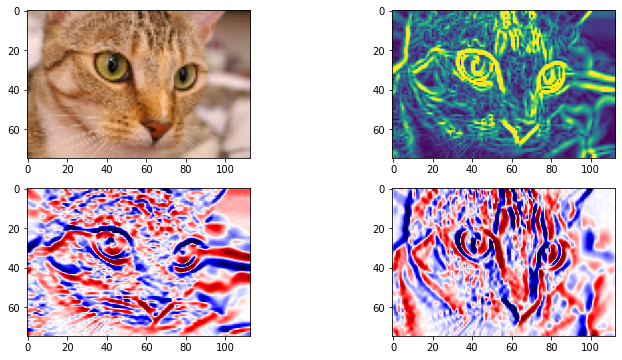

In [ ]:
import scipy.ndimage

image = skimage.data.cat()
#image = skimage.data.camera()
image = skimage.transform.rescale(image, 0.25, anti_aliasing=False, multichannel=image.ndim>2)
image = image.astype(float)
image -= image.min()
image *= (1/image.max())
image = 2*image - 1

coords = get_pixel_coords(image.shape)
D = 1 if len(image.shape)<3 else image.shape[2]  # 1 for grayscale, 3 for RGB
values_gt = torch.Tensor(2*image - 1).view(-1, D)
coords, values_gt = coords.cuda(), values_gt.cuda()

image_gradient = im_gradient(image)
gradient_gt = torch.Tensor(image_gradient).view(-1, 2*D)
gradient_gt = gradient_gt.cuda()

fig, ax = plt.subplots(2, 2, figsize=(12, 6))

if D==1:
    ax[0, 0].imshow(image, vmin=-1, vmax=1, cmap=plt.cm.gray)
    ig = image_gradient
else:
    ax[0, 0].imshow(0.5*(image + 1))
    ig = image_gradient.sum(axis=2)

ax[0, 1].imshow(np.linalg.norm(ig, axis=2), vmin=0, vmax=8*D, cmap=plt.cm.viridis)
ax[1, 0].imshow(ig[..., 0], vmin=-8*D, vmax=8*D, cmap=plt.cm.seismic)
ax[1, 1].imshow(ig[..., 1], vmin=-8*D, vmax=8*D, cmap=plt.cm.seismic)
plt.show()


Step 0, Total loss 10.382580


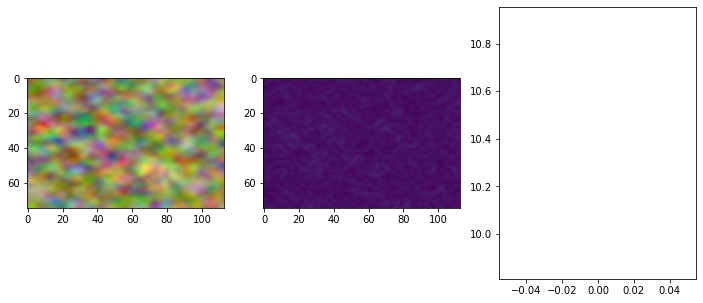

Step 50, Total loss 0.305644


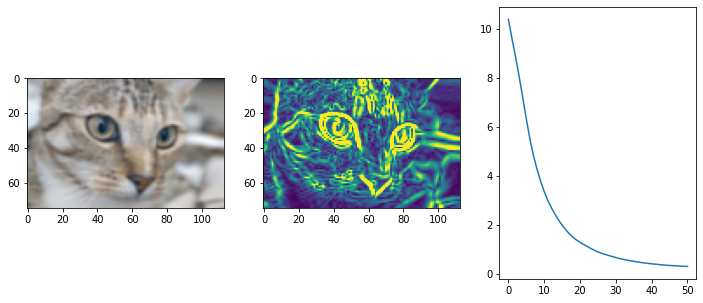

Step 100, Total loss 0.193303


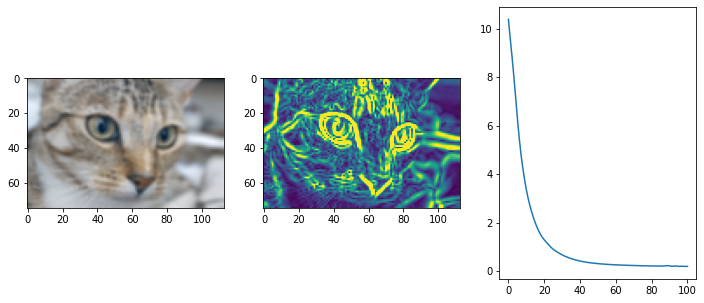

Step 150, Total loss 0.147127


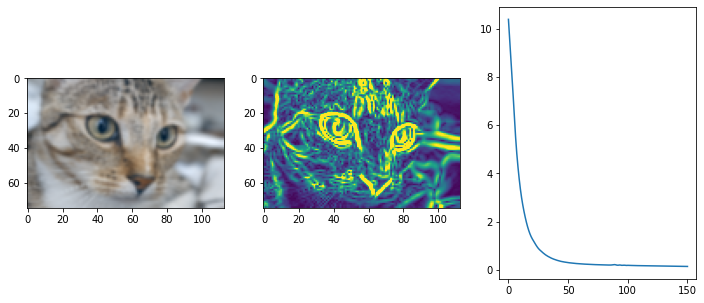

Step 200, Total loss 0.109141


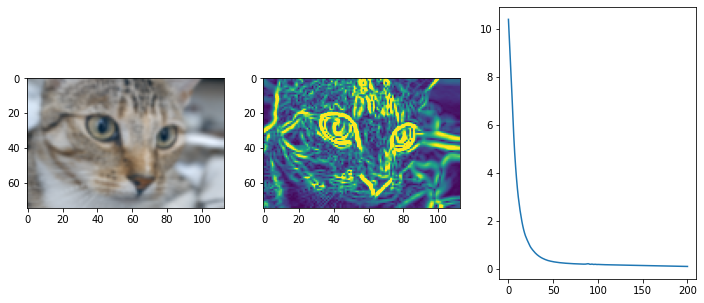

Step 250, Total loss 0.081202


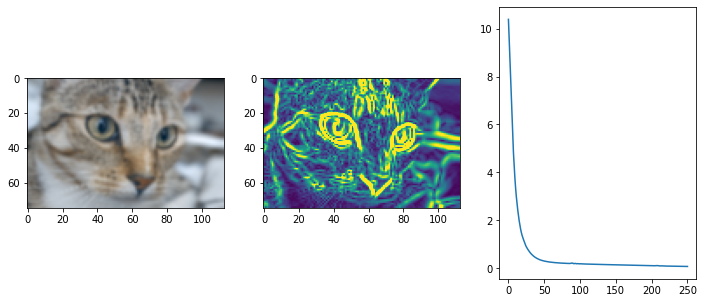

Step 300, Total loss 0.055724


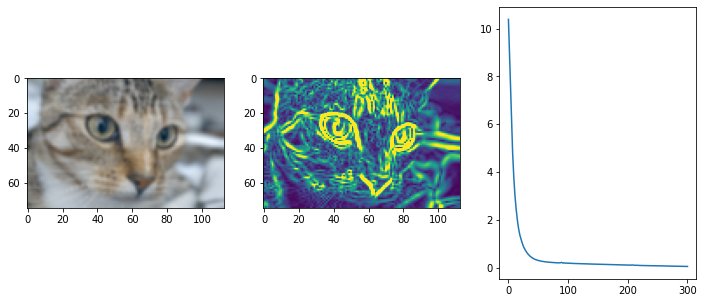

Step 350, Total loss 0.040562


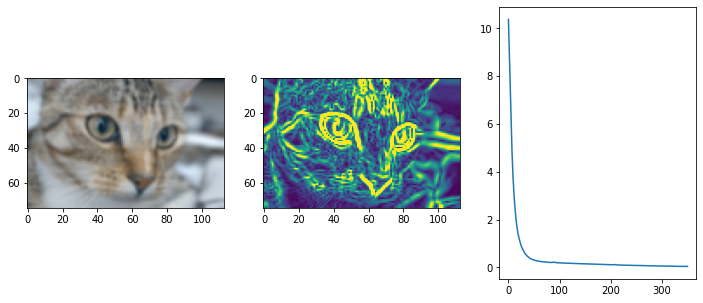

Step 400, Total loss 0.029994


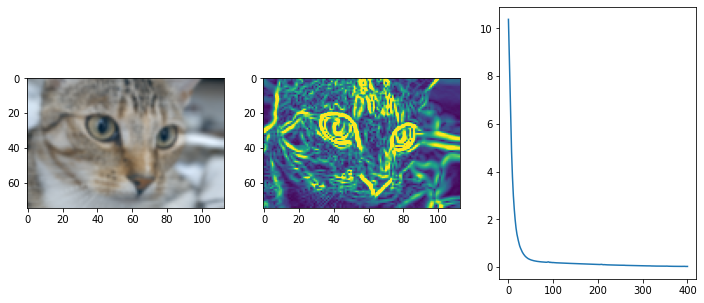

Step 450, Total loss 0.018646


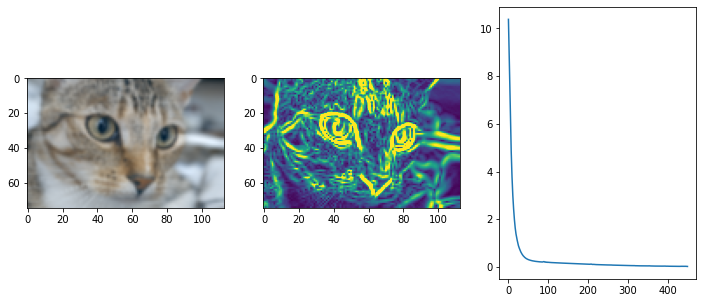

Step 500, Total loss 0.017130


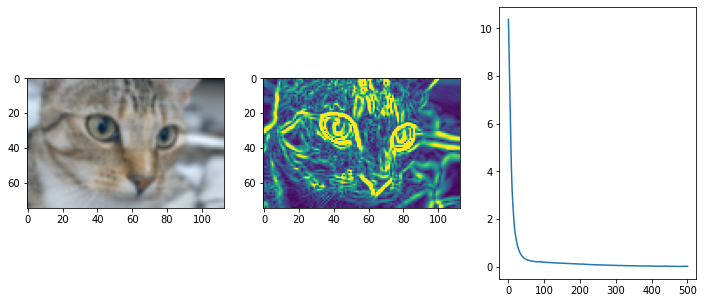

Step 550, Total loss 0.009513


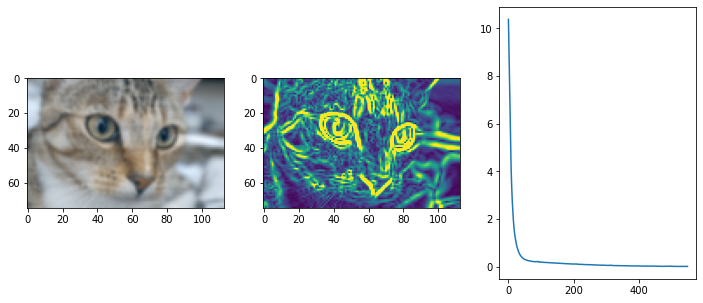

Step 600, Total loss 0.007263


Step 650, Total loss 0.006627


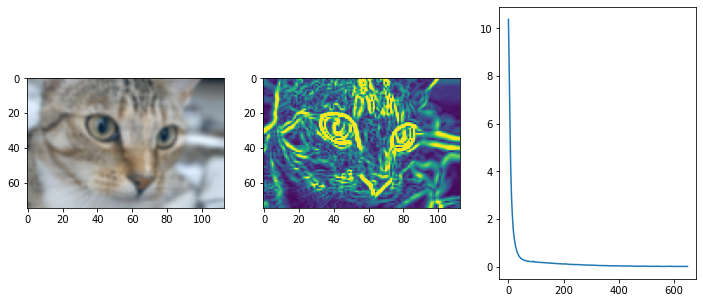

Step 700, Total loss 0.003846


Step 750, Total loss 0.003241


Step 800, Total loss 0.002838


Step 850, Total loss 0.002263


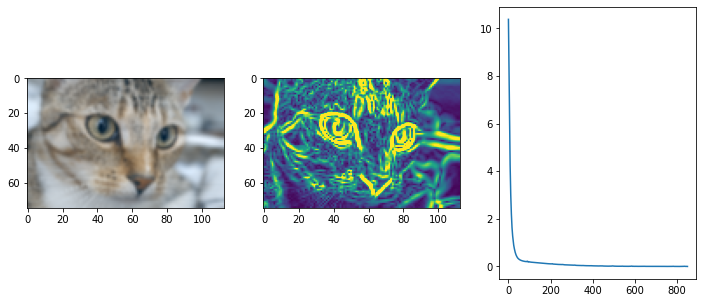

Step 900, Total loss 0.002399


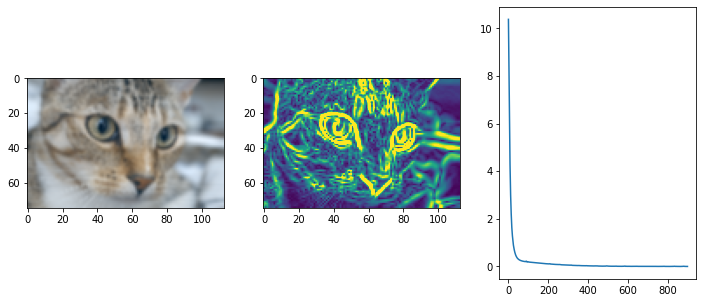

Step 950, Total loss 0.001731


Step 1000, Total loss 0.003652


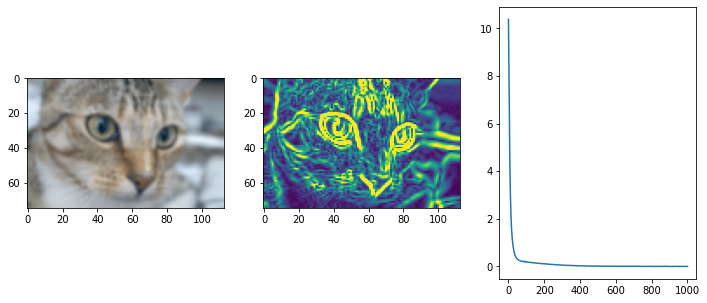

In [ ]:
model = Siren(outdim=D).cuda()

total_steps = 1001 # Since the whole image is our dataset, this is number of gradient descent steps.
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-4, params=model.parameters())
coords = coords.requires_grad_(True) # allows to take derivative w.r.t. input
losses = []

for step in range(total_steps):

    predictions = model(coords)
    gradient_predicted = gradient(predictions, coords)
    loss = ((gradient_predicted.view(-1, 2*D) - gradient_gt)**2).mean()
    losses.append(loss.item())

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        predicted_image = predictions.cpu().view(image.shape).detach().numpy()
        predicted_image -= predicted_image.min()
        predicted_image *= (1/predicted_image.max())

        gradim = gradient_predicted.cpu().norm(dim=-1).detach()
        if D>1:
            gradim = gradim.sum(dim=-1)

        fig, ax = plt.subplots(1, 3, figsize=(12,5))

        ax[0].imshow(predicted_image)
        ax[1].imshow(gradim.view(image.shape[:2]), vmin=0, vmax=8*D, cmap=plt.cm.viridis)
        ax[2].plot(losses)

        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

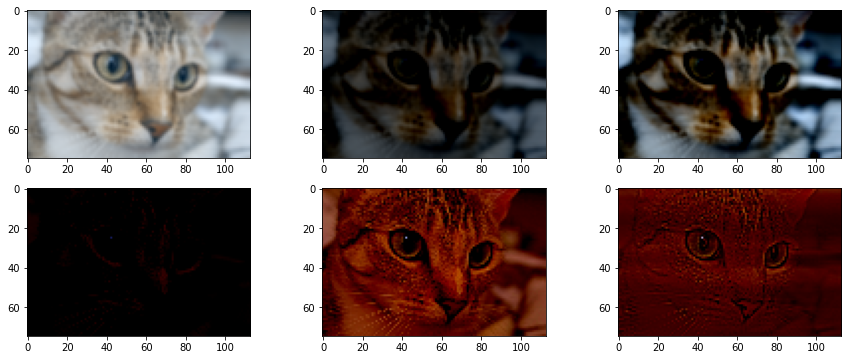

In [ ]:
# Only for grayscale images

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes[0, 0].imshow(predicted_image, vmin=-1, vmax=1, cmap=plt.cm.gray)
axes[1, 0].imshow(image - predicted_image, vmin=-2, vmax=2, cmap=plt.cm.seismic)

pi = predicted_image
pi -= 0.5*(pi.max()-pi.min())

axes[0, 1].imshow(pi, vmin=-1, vmax=1, cmap=plt.cm.gray)
axes[1, 1].imshow(image - pi, vmin=-2, vmax=2, cmap=plt.cm.seismic)

pi = predicted_image
pi -= pi.min()
pi /= pi.max()
pi = 2*pi - 1

axes[0, 2].imshow(pi, vmin=-1, vmax=1, cmap=plt.cm.gray)
axes[1, 2].imshow(image - pi, vmin=-2, vmax=2, cmap=plt.cm.seismic)

plt.show()

In [ ]:
# This is from siren notebook, as we also can fit Laplacian
#
#def divergence(y, x):
#    div = 0.
#    for i in range(y.shape[-1]):
#        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
#    return div
#
#def laplace(y, x):
#    grad = gradient(y, x)
#    return divergence(grad, x)

#image_laplacian = scipy.ndimage.laplace(image)
